## L-2 Norm attaks against CIFAR-10

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math,time
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct
from multiprocessing import Pool


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (32,32,3)
num_classes = 10

# Load/Create Network and Generate Adversarial Data

In [4]:
#%%capture one
#Load model from disk
model_name = 'cifar10-resnet'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='cifar10', transform='dct-3d',seed=SEED,project=False)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
#epochs = 200
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Learning rate:  0.001
Total Model Params: 273066
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.test_data, model.test_labels)[1]))

6073/6073 [==============================] - 3s 460us/step
Model Accuracy: 0.84900


In [5]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [6]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [7]:
%%capture four
#Get Regular, JSMA, DF, and CW test points
import time
reg_data = model.test_data[test_indices]
start_time = time.time()
cwl2_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='CW-l2')
print("--- CW-l2: %s seconds ---" % (time.time() - start_time))
start_time = time.time()
df_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='DF', nb_candidate=num_classes)
print("--- DF: %s seconds ---" % (time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
#%%capture five
#np.save('data/reg_data_cifar10_l2', reg_data)
#np.save('data/cwl2_data_cifar10_l2', cwl2_data)
#np.save('data/df_data_cifar10_l2', df_data)

In [7]:
%%capture five
reg_data = np.load('data/reg_data_cifar10_l2.npy')
cwl2_data = np.load('data/cwl2_data_cifar10_l2.npy')
df_data = np.load('data/df_data_cifar10_l2.npy')

In [8]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy CW-l2: %.5f' % (model.model.evaluate(cwl2_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy DF: %.5f' % (model.model.evaluate(df_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 2s 2ms/step
Model Accuracy REG: 0.84600
1000/1000 [==============================] - 0s 285us/step
Model Accuracy CW-l2: 0.08700
1000/1000 [==============================] - 0s 310us/step
Model Accuracy DF: 0.07700


Training Data: 


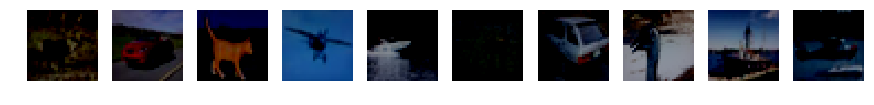

In [9]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-cifar10_l2')

Regular: 


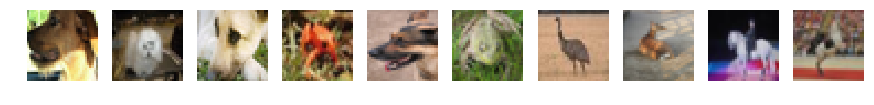

CW-l2: 


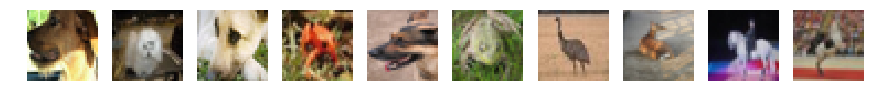

DF: 


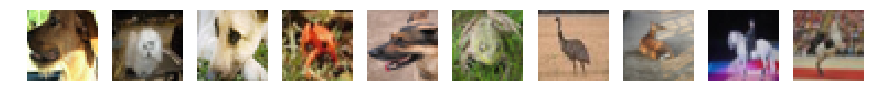

In [10]:
#Lets visualize samples from each attack
x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-cifar10_l2')
print ('CW-l2: ')
visualize(cwl2_data[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl2-cifar10_l2')
print ('DF: ')
visualize(df_data[x_vis].reshape(-1,*input_shape), 10, '../figures/df-cifar10_l2')

In [11]:
%%capture six
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
cwl2_preds = model.model.predict(cwl2_data.reshape(-1,*input_shape))
df_preds = model.model.predict(df_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
cwl2_labels = preds_to_labels(cwl2_preds)
df_labels = preds_to_labels(df_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
cwl2_idx = np.where(np.argmax(cwl2_preds, axis=1) != true_preds)[0]
df_idx = np.where(np.argmax(df_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
cwl2_data_fil = cwl2_data[cwl2_idx]
df_data_fil = df_data[df_idx]


#Filter labels to be used
cwl2_labels_fil = cwl2_labels[cwl2_idx]
df_labels_fil = df_labels[df_idx]

In [12]:
#Get l-2 distortion 
print ('CW-l2: %.5f' % (avg_l2_dist(reg_data[cwl2_idx], cwl2_data_fil)))
print ('DF: %.5f' % (avg_l2_dist(reg_data[df_idx], df_data_fil)))

CW-l2: 0.12816
DF: 0.11908


In [13]:
#Get l-0 distortion 
print ('CW-l2: %.5f' % (avg_l0_dist(reg_data[cwl2_idx], cwl2_data_fil)))
print ('DF: %.5f' % (avg_l0_dist(reg_data[df_idx], df_data_fil)))

CW-l2: 2849.00000
DF: 2542.00000


In [14]:
#Get Cwl2 norm difference
avg=0.0
ratios = []
for i,j in enumerate(cwl2_idx):
    r = np.linalg.norm(reg_data[j]-cwl2_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.004187587276886916 0.01676333 0.00013655693


In [15]:
#Get df norm difference
avg=0.0
ratios = []
for i,j in enumerate(df_idx):
    r = np.linalg.norm(reg_data[j]-df_data_fil[i])/np.linalg.norm(reg_data[j])
    ratios.append(r)
    avg+=r
print(avg/1000, max(ratios), min(ratios))

0.003888616767107578 0.024558548 3.0476413e-06


# BP Reconstruction

In [16]:
n = 32*32
#Form the DCT matrix
D = get_matrix(n=32*32)
D_T = D.T

In [17]:
clean_r,clean_g,clean_b = [],[],[]
args_r,args_g,args_b =[],[],[] 

In [18]:
def clean_sample(a):
    x_adv,D, n, eta = a
    x_hat = socp(x_adv.flatten(),D,n=n,eta=eta)
    return x_hat

In [19]:
for i in range(num_test_samples):
    args_r.append( (cwl2_data[i,:,:,0],D_T,n,0.12816))
    args_g.append( (cwl2_data[i,:,:,1],D_T,n,0.12816))
    args_b.append( (cwl2_data[i,:,:,2],D_T,n,0.12816))

In [20]:
my_args = [args_r, args_g, args_b]
my_clean = [clean_r, clean_g, clean_b]

In [ ]:
%%capture pooling
p = Pool(10)
st = time.time()
for idx,args in enumerate(my_args):
    my_clean[idx] = p.map(clean_sample, args)
print(time.time() - st)
p.terminate()

In [ ]:
%%capture collecting
clean_cwl2 = np.zeros(cwl2_data.shape)
for i in range(num_test_samples):
    clean_cwl2[i,:,:,0] = idct(my_clean[0][i].flatten(),norm='ortho').reshape(32,32)
    clean_cwl2[i,:,:,1] = idct(my_clean[1][i].flatten(),norm='ortho').reshape(32,32)
    clean_cwl2[i,:,:,2] = idct(my_clean[2][i].flatten(),norm='ortho').reshape(32,32)

In [23]:
%%capture saving
np.save('data/clean_cifar10_cwl2_l2', clean_cwl2)

In [32]:
#Used same reconstruction process for Deepfool on a separate notebook
clean_df = np.load('data/clean_cifar10_df_l2.npy')
clean_cw = np.load('data/clean_cifar10_cwl2_l2.npy')

In [ ]:
#x_vis = np.random.choice(range(0,num_test_samples), 10)
visualize(clean_df[x_vis].reshape(-1,*input_shape), 10, '../figures/df-clean-cifar10_l2-socp')
visualize(clean_cwl2[x_vis].reshape(-1,*input_shape), 10, '../figures/cwl2-clean-cifar10_l2-socp')

In [ ]:
print ('Model Accuracy Reconstructed CW-l2: %.5f' % (model.model.evaluate(clean_cwl2,model.test_labels[test_indices])[1]))
print ('Model Accuracy Reconstructed DF: %.5f' % (model.model.evaluate(clean_df,model.test_labels[test_indices])[1]))